## Loading Data

### Read Csv

In [29]:
import pandas as pd

df = pd.read_csv('../Datasets/hate-speech-detection-curated-dataset/HateSpeechDatasetBalanced.csv', encoding='utf-8')

In [25]:
df.head(10)

,text,label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1
5,yeah retard haha,1
6,the ching chong chung stuff,1
7,the dead what a slut still warm when she tweet...,1
8,let your tweets be harmless it will not affect...,1
9,these latinos who have a problem with immigrat...,1


In [34]:
null_per_column = df.isnull().sum()
print("Null values per column:\n", null_per_column)
total_duplicates = df.duplicated().sum()
print("Total duplicate rows in DataFrame:", total_duplicates)

Null values per column:
 text     0
label    0
dtype: int64
Total duplicate rows in DataFrame: 0


In [31]:
df = df.dropna().drop_duplicates()

### Checking the data balance

In [32]:
df[df['label'] == 0].count()

text     341976
label    341976
dtype: int64

In [33]:
df[df['label'] == 1].count()

text     359097
label    359097
dtype: int64

<Axes: xlabel='label', ylabel='count'>

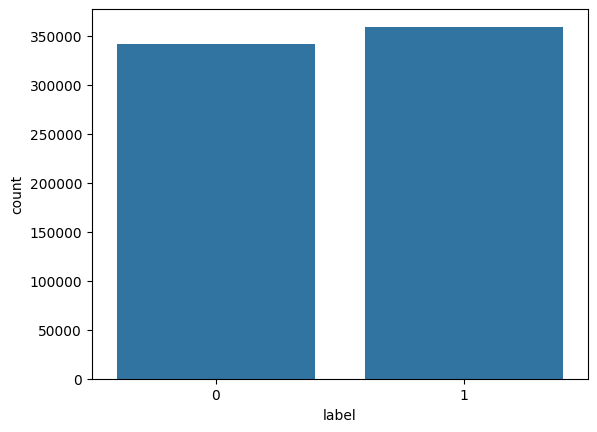

In [35]:
import seaborn as sns

sns.countplot(x='label', data=df)

### Downsample to balance the data

In [36]:
# Separate DataFrames for label 0 and label 1
df_label_0 = df[df['label'] == 0]
df_label_1 = df[df['label'] == 1]

# Get the minimum size of both groups to balance them
min_size = min(len(df_label_0), len(df_label_1))

# Randomly sample from both groups to balance
df_label_0_balanced = df_label_0.sample(n=min_size, random_state=42)
df_label_1_balanced = df_label_1.sample(n=min_size, random_state=42)

# Concatenate the two balanced DataFrames
df = pd.concat([df_label_0_balanced, df_label_1_balanced])

# Shuffle the rows to mix the labels
df = df.sample(frac=1, random_state=69).reset_index(drop=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683952 entries, 0 to 683951
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    683952 non-null  object
 1   label   683952 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.4+ MB


### Checking the data balance after downsample

<Axes: xlabel='label', ylabel='count'>

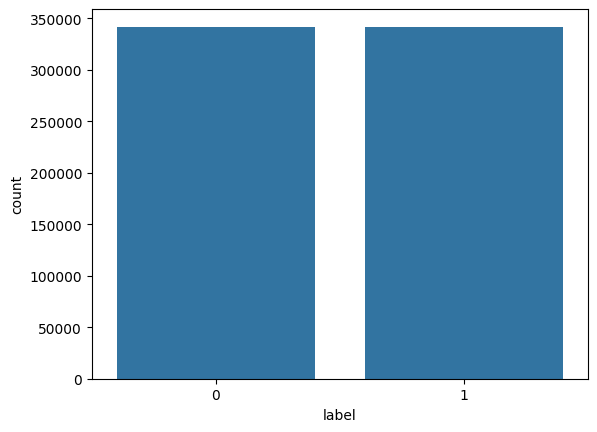

In [38]:
import seaborn as sns

sns.countplot(x='label', data=df)

## Preprocessing Data

### Create functions to process text data

In [9]:
import re
# from nltk.stem import PorterStemmer
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

# def lemmatize_words(tokenize_text):
#    lemmatizer = WordNetLemmatizer()

#    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenize_text]

#    return lemmatized_words

# def stem_words(tokenized_text):
#     stemmer = PorterStemmer()
    
#     stemmed_words = [stemmer.stem(word) for word in tokenized_text]

#     return stemmed_words

# def remove_stopwords(tokenized_text):
#     stop_words = set(stopwords.words('english'))
    
#     filtered_words = [word for word in tokenized_text if word.lower() not in stop_words]

#     return filtered_words

def remove_longwords(tokenized_text):
    filtered_words = [word for word in tokenized_text if len(word) <=45]

    return filtered_words
   

def remove_extra_spaces(text):
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()
  return text

def join_words(tokenized_text):
   return ' '.join(tokenized_text)

def tokenize_text(text):
   return word_tokenize(text)

ModuleNotFoundError: No module named 'nltk'

In [11]:
def clean_text(text):
  # return join_words(stem_words(remove_stopwords(tokenize_text(text))))
  return join_words(lemmatize_words(remove_longwords(tokenize_text(text))))

### Applying text cleaner function

In [12]:
df['text'] = df['text'].apply(clean_text)
df.head(100)

,text,label
0,it is your translation that is where are you o...,0
1,you not be aware of this but a cocktail is cer...,0
2,well perhaps you could explain exactly what yo...,0
3,indexing by saddam or by hussein a recent edit...,0
4,a well a the role and the behavior of the invo...,0
...,...,...
95,she can not wear a bikini a she is chubby,0
96,harrison s flower le flour d harrison if one w...,0
97,yes indeed camel ostrich and zebra vccamelraces,0
98,your recent edits hello weinberg please do not...,0


### Deleting data that has string empty text

In [7]:
# len(df[df['text'].str.split().str.len() < 1])
# len(df[df['text'] == ''].values)
df = df[df['text'] != '']

### Creating wordcloud

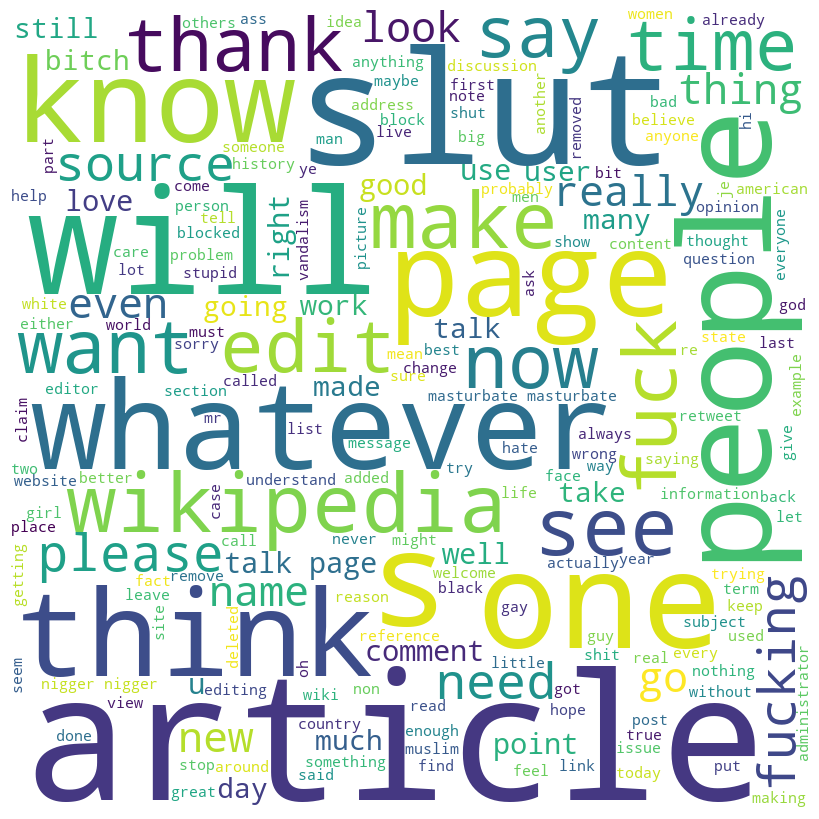

In [13]:
wc = ''

for words in df['text'].values:
  wc += ' '+words

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(wc)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Creating word index

In [39]:
import re

def generate_word_index(texts):
    word_index = {}
    index = 1  # Start indexing from 1, reserve index 0 for unknown words
    for text in texts:
        tokens = re.findall(r'\w+', text.lower())
        for token in tokens:
            if token not in word_index:
                word_index[token] = index
                index += 1
    return word_index

word_index = generate_word_index(df['text'].values)
len(word_index)

136803

### Calculating longest text by words

In [40]:
longest_text = 0
for text in df['text'].values:
  if len(text.split(' ')) > longest_text:
    longest_text = len(text.split(' '))

longest_text

310

### Tokenizing words based on created word index

In [41]:
df_ready_to_train = df.copy()
df_ready_to_train['token'] = df_ready_to_train['text'].apply(lambda text: [word_index.get(word, 0) for word in re.split(r'\W+', text.lower())])

In [42]:
import tensorflow as tf

df_ready_to_train['token'] = list(tf.keras.preprocessing.sequence.pad_sequences(df_ready_to_train['token'], maxlen=longest_text, padding='post'))

In [51]:
df_ready_to_train = df_ready_to_train.drop(columns=['text'])

## Saving Data

In [52]:
SAVE_PATH = '../Datasets/processed-en-683k/'

### Creating Map

In [53]:
metadata = {}

### Saving general information

In [54]:
from datetime import datetime

metadata['name'] = 'optimalisasi-model-machine-learning-untuk-klasifikasi-ujaran-kebencian-pada-x-twitter'
metadata['author'] = 'doddy-s'
metadata['created_at'] = datetime.now().isoformat()
metadata['meta'] = {}

### Saving dataset metadata

In [56]:
dataset_file_name = 'english-hate-speech-processed-dataset'
dataset_file_format = 'csv'

metadata['meta']['dataset'] = {}
metadata['meta']['dataset']['longest_text'] = longest_text
metadata['meta']['dataset']['count'] = int(df_ready_to_train['token'].count())
metadata['meta']['dataset']['file_name'] = dataset_file_name
metadata['meta']['dataset']['file_format'] = dataset_file_format

### Saving dataset-ready-to-train metadata

In [57]:
dataset_ready_to_train_file_name = 'english-hate-speech-processed-dataset-ready-to-train'
dataset_ready_to_train_file_format = 'parquet'

metadata['meta']['dataset_ready_to_train'] = {}
metadata['meta']['dataset_ready_to_train']['longest_text'] = longest_text
metadata['meta']['dataset_ready_to_train']['count'] = int(df_ready_to_train['token'].count())
metadata['meta']['dataset_ready_to_train']['file_name'] = dataset_ready_to_train_file_name
metadata['meta']['dataset_ready_to_train']['file_format'] = dataset_ready_to_train_file_format

### Saving word index metadata

In [58]:
word_index_file_name = 'english-hate-speech-processed-word-index'
word_index_file_format = 'json'

metadata['meta']['word_index'] = {}
metadata['meta']['word_index']['count'] = len(word_index)
metadata['meta']['word_index']['file_name'] = word_index_file_name
metadata['meta']['word_index']['file_format'] = word_index_file_format

### Exporting metadata to json file

In [59]:
import json

with open(SAVE_PATH+'metadata.json', 'w') as json_file:
  json.dump(metadata, json_file, indent=2)

### Exporting datasets

In [60]:
df.to_csv(SAVE_PATH+dataset_file_name+'.'+dataset_file_format, index=False, encoding='utf-8')
df_ready_to_train.to_parquet(SAVE_PATH+dataset_ready_to_train_file_name+'.'+dataset_ready_to_train_file_format)

with open(SAVE_PATH+word_index_file_name+'.'+word_index_file_format, 'w') as json_file:
  json.dump(word_index, json_file, indent=2)